#### <b>Download the Dataset</b>
Linux 환경에서만 실행 가능. Windows에서는 직접 다운로드해야 함

In [2]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/Eb1hztk047VFk2j9bI7JKmEBtkWpABZ8vfX5_m0cdSjQHw?download=1 -O custom_korean_family_dataset_resolution_256.zip
!unzip custom_korean_family_dataset_resolution_256.zip -d ./custom_korean_family_dataset_resolution_256

#### <b>Load Libraries</b>

In [1]:
!pip install facenet_pytorch

You should consider upgrading via the 'c:\users\user\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [3]:
import pandas as pd
import random
import os
from PIL import Image
from torch.utils.data import Dataset

import torch
import torch.nn as nn

from facenet_pytorch import InceptionResnetV1
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
"""
> [Function] Parse the metadata.
* family_list = ["F0001", "F0002", ...]
* family_to_person_map["F0001"] = ["D", "GM", "M"]
* person_to_image_map["F0001_D"] = [
    "F0001_AGE_D_18_a1.jpg",
    "F0001_AGE_D_18_a2.jpg",
    ...
]
"""
def parsing(metadata): #가족 종류, 가족->인물, 인물->이미지 dict 생성
    family_set = set()
    family_to_person_map = dict()
    person_to_image_map = dict()
    # iterate all rows in the metadata file
    for idx, row in metadata.iterrows():
        family_id = row["family_id"]
        person_id = row["person_id"]
        key = family_id + "_" + person_id
        image_path = row["image_path"]
        if family_id not in family_set:
            family_set.add(family_id)
            family_to_person_map[family_id] = []
        if person_id not in family_to_person_map[family_id]:
            family_to_person_map[family_id].append(str(person_id))    
            person_to_image_map[key] = []
        person_to_image_map[key].append(image_path) # save all image paths
    family_list = list(family_set)
    return family_list, family_to_person_map, person_to_image_map

## <b>Configuration</b>
* 모델의 기본적인 설정들을 수정할 수 있습니다.

In [ ]:
wts = [200,1,0.005] #세대 차이에 따른 가중치. 순서대로 동일,1세대,2세대 차이
num_epochs = 5 #에포크 수
dataloader_batch_size = 32 #배치 크기
lr = 0.001 #learning_rate
log_step = 20 #log가 출력되는 주기(단위 : 배치)
scheduler_patience = 10 #learning_rate 감소 주기
SAVE_EVERY_EPOCH = False #모든 에포크 모델을 저장할 지 여부. False일 시 최고 검증 정확도 갱신 시에만 저장

아래의 값들은 수정 가능하지만 가급적 수정하지 않는 것을 권장드립니다.

In [ ]:
change = {'D':0,'D2':0,'D3':0,'D4':0,'S':0,'S2':0,'S3':0,'S4':0,'F':1,'M':1,'GF':2,'GM':2} #지위별 세대 번호

#### <b>Load Datasets</b>

* Training dataset
  * (F0001 ~ F0299) folders have 10,025 images.
* Validation dataset
  * (F0801 ~ F0850) folders have 1,539 images.
* Test dataset
  * (F0851 ~ F0900) folders have 1,504 images.

In [6]:
class TrainDataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # 메타데이터 파싱
        family_list, family_to_person_map, person_to_image_map = parsing(meta_data)
        self.family_list = family_list
        self.family_to_person_map = family_to_person_map
        self.person_to_image_map = person_to_image_map

    def __len__(self):
        return len(self.meta_data) * 2
               
    def __getitem__(self, idx):
        # 같은 가족 샘플 추출(양성)
        if idx % 2 == 0:
            # 무작위 가족 선택
            family_id = random.choice(self.family_list)
            # 가족 내에서 서로 다른 사람 무작위 선택
            p1, p2 = random.sample(self.family_to_person_map[family_id], 2) 
            key1 = family_id + "_" + p1
            key2 = family_id + "_" + p2
            label = 1
        # 다른 가족 샘플 추출(음성)
        else:
            # 서로 다른 두 가족 무작위 선택
            f1, f2 = random.sample(self.family_list, 2)
            # 가족별로 무작위 사람 선택
            p1 = random.choice(self.family_to_person_map[f1])
            p2 = random.choice(self.family_to_person_map[f2])
            key1 = f1 + "_" + p1
            key2 = f2 + "_" + p2
            label = 0
        
        #인물마다 무작위로 이미지 경로 추출
        path1 = random.choice(self.person_to_image_map[key1])
        path2 = random.choice(self.person_to_image_map[key2])

        #인물의 지위 추출, 세대 차이에 따른 가중치 계산
        v1 = change[path1.split('_')[2]]
        v2 = change[path2.split('_')[2]]
        weight=wts[abs(v1-v2)]

        #이미지 오픈
        img1 = Image.open(os.path.join(self.image_directory, path1))
        img2 = Image.open(os.path.join(self.image_directory, path2))

        #transform 적용
        if self.transform:
            img1, img2 = self.transform(img1), self.transform(img2)
        
        return img1, img2, label, weight

In [7]:
class EvaluationDataset(Dataset):
    def __init__(self, image_directory, transform=None):
        #샘플이 담긴 폴더 및 리스트 불러오기
        self.positive_folder = os.path.join(image_directory, "positive")
        self.negative_folder = os.path.join(image_directory, "negative")
        self.positive_list = os.listdir(self.positive_folder)
        self.negative_list = os.listdir(self.negative_folder)
        self.transform = transform

    def __len__(self):
        return len(self.positive_list) + len(self.negative_list)

    def __getitem__(self, idx):
        # 같은 가족 샘플 추출(양성)
        if idx % 2 == 0:
            result_folder = os.path.join(self.positive_folder, self.positive_list[idx // 2])
            file1, file2 = os.listdir(result_folder)
            label = 1
        # 다른 가족 샘플 추출(음성)
        else:
            result_folder = os.path.join(self.negative_folder, self.negative_list[idx // 2])
            file1, file2 = os.listdir(result_folder)
            label = 0
        
        #인물의 지위 추출, 세대 차이에 따른 가중치 계산
        v1 = change[file1.split('_')[2]]
        v2 = change[file2.split('_')[2]]
        weight=wts[abs(v1-v2)]
        
        #이미지 오픈
        img1 = Image.open(os.path.join(result_folder, file1))
        img2 = Image.open(os.path.join(result_folder, file2))
        
        #transform 적용
        if self.transform:
            img1, img2 = self.transform(img1), self.transform(img2)

        return img1, img2, label, weight

In [8]:
from torchvision import transforms
from torch.utils.data import DataLoader

#데이터 경로
train_meta_data_path = "./custom_korean_family_dataset_resolution_256/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_256/train_images"

val_image_directory = "./custom_korean_family_dataset_resolution_256/fixed_val_dataset"
test_image_directory = "./custom_korean_family_dataset_resolution_256/fixed_test_dataset"

#transform 제작
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

#dataset, dataloader 생성
train_dataset = TrainDataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=dataloader_batch_size, shuffle=True, num_workers=0)

val_dataset = EvaluationDataset(val_image_directory, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=dataloader_batch_size, shuffle=False, num_workers=0)

test_dataset = EvaluationDataset(test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=dataloader_batch_size, shuffle=False, num_workers=0)

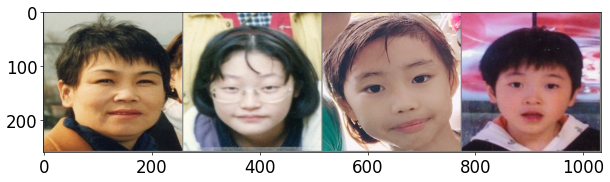

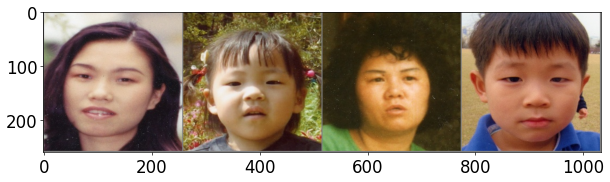

tensor([1, 0, 0, 1])


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(input):
    # Tensor -> numpy 배열
    input = input.numpy().transpose((1, 2, 0))
    # 이미지 정규화 해제
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # 이미지 표스
    plt.imshow(input)
    plt.show()

# dataloader에서 이미지 배치 불러오기
iterator = iter(train_dataloader)

# 이미지 표시
img1, img2, label, weight = next(iterator)
out = torchvision.utils.make_grid(img1[:4])
imshow(out)
out = torchvision.utils.make_grid(img2[:4])
imshow(out)
print(label[:4]) # 1: 양성, 0: 음성

#### <b>Define Models</b>

In [11]:
class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()

        #encoder 모델 불러오기
        self.encoder = InceptionResnetV1(pretrained='vggface2')
        #encoder 모델의 출력 차원
        self.emb_dim = 512

        #encoder 모델의 결과를 통해 유사도 계산
        self.last = nn.Sequential(
            nn.Linear(4 * self.emb_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
        
    def forward(self, input1, input2):
        emb1 = self.encoder(input1)
        emb2 = self.encoder(input2)
        
        x1 = torch.pow(emb1, 2) - torch.pow(emb2, 2)
        x2 = torch.pow(emb1 - emb2, 2)
        x3 = emb1 * emb2
        x4 = emb1 + emb2
        
        x = torch.cat((x1, x2, x3, x4), dim=1)
        x = self.last(x)

        return x

#### <b>Train a Model</b>

In [12]:
import time

#모델 불러오기
net = SiameseNet().cuda()
net = torch.nn.DataParallel(net)

criterion = nn.BCEWithLogitsLoss(reduction="none")
optimizer = torch.optim.SGD(net.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, patience=10)
sigmoid = nn.Sigmoid()

100.0%


In [13]:
def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    net.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        
        img1, img2, label, weight = batch #dataloader에서 batch 불러오기
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.cuda()
        output = net(img1, img2) #불러온 데이터를 모델에 적용
        preds = sigmoid(output) >= 0.5 #정확도 계산
        
        loss = criterion(output, label)
        loss = loss * (weight.unsqueeze(1)) #loss에 가중치 곱하기
        loss = torch.mean(loss)
        
        loss.backward()
        optimizer.step()
        
        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == (label >= 0.5))
        
        if i % log_step == log_step - 1: #log_step마다 log 출력
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, running_corrects / total


def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    net.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):

        img1, img2, label, weight = batch #dataloader에서 batch 불러오기
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.cuda()
        with torch.no_grad(): #학습 없이 실행
            output = net(img1, img2)
            preds = sigmoid(output) >= 0.5 #정확도 계산
            loss = criterion(output, label)
            loss = loss * (weight.unsqueeze(1)) #loss에 가중치 곱하기
            loss = torch.mean(loss)

        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == (label >= 0.5))

        if i % log_step == log_step - 1: #log_step마다 log 출력
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, running_corrects / total

In [15]:
#net.load_state_dict(torch.load("/content/drive/MyDrive/Colabresult/last_checkpoint_epoch_10.pth"))
best_val_acc = 0
best_epoch = 0
sum_loss=0
sum_acc=0

history = []
accuracy = []
for epoch in range(num_epochs):
    #train과 validate
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    #기록 추가
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))
    scheduler.step(val_loss)
    sum_loss += val_loss
    sum_acc += val_acc

    if val_acc > best_val_acc or SAVE_EVERY_EPOCH: #loss의 최저치가 갱신된다면
        if val_acc > best_val_acc:
            print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        #네트워크 저장
        torch.save(net.state_dict(), f'./best_checkpoint_epoch_{epoch + 1}.pth')

#최종 네트워크 상태 저장
torch.save(net.state_dict(), f'./last_checkpoint_epoch_{num_epochs}.pth')

#평균 loss, accuracy 출력
print(f"mean val loss: {sum_loss/num_epochs}, mean val accuracy: {sum_acc/num_epochs}")

[Epoch: 1 - Training]
[Batch: 20] running train loss: 1.0976944006143186, running train accuracy: 0.4906249940395355
[Batch: 40] running train loss: 1.1326246316226856, running train accuracy: 0.50390625
[Batch: 60] running train loss: 1.0873906757106842, running train accuracy: 0.5125000476837158
[Batch: 80] running train loss: 1.111008992846415, running train accuracy: 0.5062500238418579
[Batch: 100] running train loss: 1.0623342073078665, running train accuracy: 0.5043749809265137
[Batch: 120] running train loss: 1.0475862552922628, running train accuracy: 0.5036458373069763
[Batch: 140] running train loss: 1.0589790026890569, running train accuracy: 0.5035714507102966
[Batch: 160] running train loss: 1.0459276410719531, running train accuracy: 0.503125011920929
[Batch: 180] running train loss: 1.0453514625567906, running train accuracy: 0.5045139193534851
[Batch: 200] running train loss: 1.0700751155847927, running train accuracy: 0.5026562213897705
[Batch: 220] running train loss:

KeyboardInterrupt: 

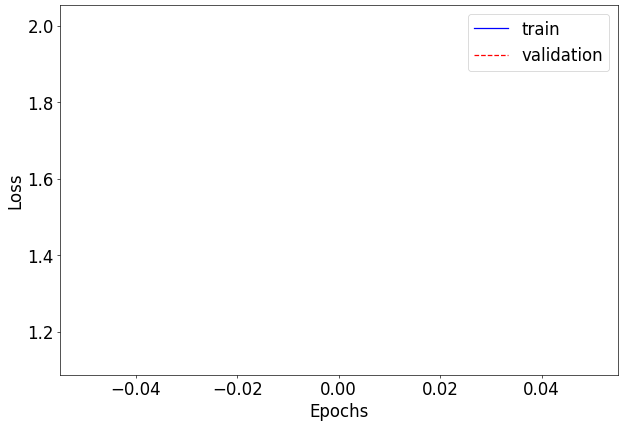

In [16]:
#loss 그래프 출력
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [18]:
#최저 loss 모델 불러오기
net.load_state_dict(torch.load('./best_checkpoint_epoch_'+str(best_epoch+1)+'.pth'))
print('best epoch is',best_epoch+1)
def test():
    start_time = time.time()
    net.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):

        img1, img2, label, weight = batch #dataloader에서 batch 불러오기
        img1, img2, label, weight = img1.cuda(), img2.cuda(), label.float().view(-1, 1).cuda(), weight.cuda()
        with torch.no_grad():
            output = net(img1, img2)
            preds = sigmoid(output) >= 0.5 #정확도 계산
            loss = criterion(output, label)
            loss = loss * (weight.unsqueeze(1)) #loss에 가중치 곱하기
            loss = torch.mean(loss)

        total += label.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == (label >= 0.5))

        if (i == 0) or (i % log_step == log_step - 1): #log_step마다 log 출력
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test  loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, running_corrects / total
#validate()
test() #불러온 모델 테스트

best epoch is 1
[Batch: 1] running test loss: 1.2913473844528198, running test accuracy: 0.5
[Batch: 20] running test loss: 1.940829873085022, running test accuracy: 0.5
[Batch: 40] running test loss: 1.9068825955290958, running test accuracy: 0.5
[Batch: 60] running test loss: 1.9010159866743197, running test accuracy: 0.5
[Batch: 80] running test loss: 1.931230002398261, running test accuracy: 0.5
[Batch: 100] running test loss: 1.9391985770668878, running test accuracy: 0.5
[Batch: 120] running test loss: 1.942436912374885, running test accuracy: 0.5
[Batch: 140] running test loss: 1.9528265541938299, running test accuracy: 0.5
[Batch: 160] running test loss: 1.9313627680519159, running test accuracy: 0.5
[Batch: 180] running test loss: 1.943471481877692, running test accuracy: 0.5
[Batch: 200] running test loss: 1.9355773041946835, running test accuracy: 0.5
[Batch: 220] running test loss: 1.9304643008648201, running test accuracy: 0.4999999701976776
[Batch: 240] running test loss:

(1.9342617103348414, tensor(0.5000, device='cuda:0'))